<a href="https://www.kaggle.com/code/ibrahimnibrahim/eye-fundus-vessel-segmentation-test-iou-0-84?scriptVersionId=244216328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/fundus-image-dataset-for-vessel-segmentation
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Ground truth
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test/Original
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/train
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/train/Ground truth
/kaggle/input/fundus-image-dataset-for-vessel-segmentation/train/Original


In [2]:
!pip install -qq segmentation-models
!pip install -qq efficientnet tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["OPENCV_LOG_LEVEL"] = "FATAL"

import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

2025-06-07 11:47:52.105813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749296872.613129      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749296872.754615      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [4]:
BACKBONE = 'efficientnetb6'
BATCH_SIZE = 4
EPOCHS = 20
LR = 0.001
IMAGE_SIZE = (512, 512)
NUM_CLASSES = 1  
TRAIN_DIR = '/kaggle/input/fundus-image-dataset-for-vessel-segmentation/train'
TEST_DIR = '/kaggle/input/fundus-image-dataset-for-vessel-segmentation/test'

# Set framework for segmentation_models
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [5]:
train_images_dir = os.path.join(TRAIN_DIR, 'Original')
train_masks_dir = os.path.join(TRAIN_DIR, 'Ground truth')

test_images_dir = os.path.join(TEST_DIR, 'Original')
test_masks_dir = os.path.join(TEST_DIR, 'Ground truth')

In [6]:
train_image_files = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if f.endswith('.png')])
train_mask_files = sorted([os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir) if f.endswith('.png')])

test_image_files = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.png')])
test_mask_files = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir) if f.endswith('.png')])

In [7]:
def data_generator(image_paths, mask_paths, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES, img_size=IMAGE_SIZE):
    while True:
        # Create shuffled indices safely
        indices = list(range(len(image_paths)))
        random.shuffle(indices)
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_masks = []
            
            for idx in batch_indices:
                try:
                    # Try loading with OpenCV first
                    img = cv2.imread(image_paths[idx])
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        raise ValueError("OpenCV failed to read mask")
                        
                except Exception as cv_error:
                    # Fallback to PIL if OpenCV fails
                    try:
                        with Image.open(image_paths[idx]) as img_pil:
                            img = np.array(img_pil.convert('RGB'))
                        with Image.open(mask_paths[idx]) as mask_pil:
                            mask = np.array(mask_pil.convert('L'))
                    except Exception as pil_error:
                        print(f"Skipping corrupt files: {image_paths[idx]}, {mask_paths[idx]}")
                        print(f"Errors - OpenCV: {cv_error}, PIL: {pil_error}")
                        continue
                
                # Preprocess with type consistency
                img, mask = preprocess_data(img, mask, num_classes, img_size)
                
                batch_images.append(img)
                batch_masks.append(mask)
            
            # Skip empty batches
            if len(batch_images) == 0:
                continue
                
            yield np.array(batch_images, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

def preprocess_data(img, mask, num_classes=NUM_CLASSES, img_size=IMAGE_SIZE):
    """Enhanced preprocessing with better type handling"""
    # Resize using INTER_NEAREST for masks to avoid artifacts
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
    
    # Normalize and ensure correct types
    img = (img / 255.0).astype(np.float32)
    
    if num_classes == 1:
        mask = (mask / 255.0).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)
    else:
        # For multi-class: one-hot encode and ensure float32
        mask = tf.keras.utils.to_categorical(mask, num_classes).astype(np.float32)
    
    return img, mask

In [8]:
# **ADD THIS CHECK**
print(f"Number of training images: {len(train_image_files)}")
print(f"Number of validation images: {len(test_image_files)}")

Number of training images: 600
Number of validation images: 200


In [9]:
# Create data generators
train_gen = data_generator(train_image_files, train_mask_files)
val_gen = data_generator(test_image_files, test_mask_files)

In [10]:
# Define model
def get_model(backbone=BACKBONE, img_size=IMAGE_SIZE, num_classes=NUM_CLASSES):
    # Preprocess input based on backbone
    preprocess_input = sm.get_preprocessing(backbone)

    # Define model
    model = sm.Unet(
        backbone,
        encoder_weights='imagenet',
        classes=num_classes,
        activation='sigmoid' if num_classes == 1 else 'softmax',
        input_shape=(img_size[0], img_size[1], 3)
    )

    # Compile model
    model.compile(
        optimizer=Adam(LR),
        loss=sm.losses.bce_jaccard_loss if num_classes == 1 else sm.losses.categorical_crossentropy,
        metrics=[sm.metrics.iou_score]
    )

    return model

model = get_model()

I0000 00:00:1749296896.486968      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749296896.487704      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


165527152/165527152 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]


steps_per_epoch = len(train_image_files) // BATCH_SIZE
validation_steps = len(test_image_files) // BATCH_SIZE

# Train model
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  # Added steps_per_epoch
    validation_data=val_gen,
    validation_steps=validation_steps, # Added validation_steps
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1749297064.108167      72 service.cc:148] XLA service 0x7d1a74046e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749297064.109579      72 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749297064.109623      72 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749297078.416921      72 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749297092.511824      72 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749297092.682417      72 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-07 11:51:39.235679: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for

150/150 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - iou_score: 0.3511 - loss: 0.9125 - val_iou_score: 0.4580 - val_loss: 0.7349 - learning_rate: 0.0010
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 140s 937ms/step - iou_score: 0.7836 - loss: 0.2625 - val_iou_score: 0.7323 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 140s 935ms/step - iou_score: 0.8220 - loss: 0.2214 - val_iou_score: 0.7960 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 137s 912ms/step - iou_score: 0.8323 - loss: 0.2118 - val_iou_score: 0.8005 - val_loss: 0.2563 - learning_rate: 0.0010
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 903ms/step - iou_score: 0.8353 - loss: 0.2148 - val_iou_score: 0.8250 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 900ms/step - iou_score: 0.8478 - loss: 0.1966 - val_iou_score: 0.8011 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 135s 899ms/step - iou_scor

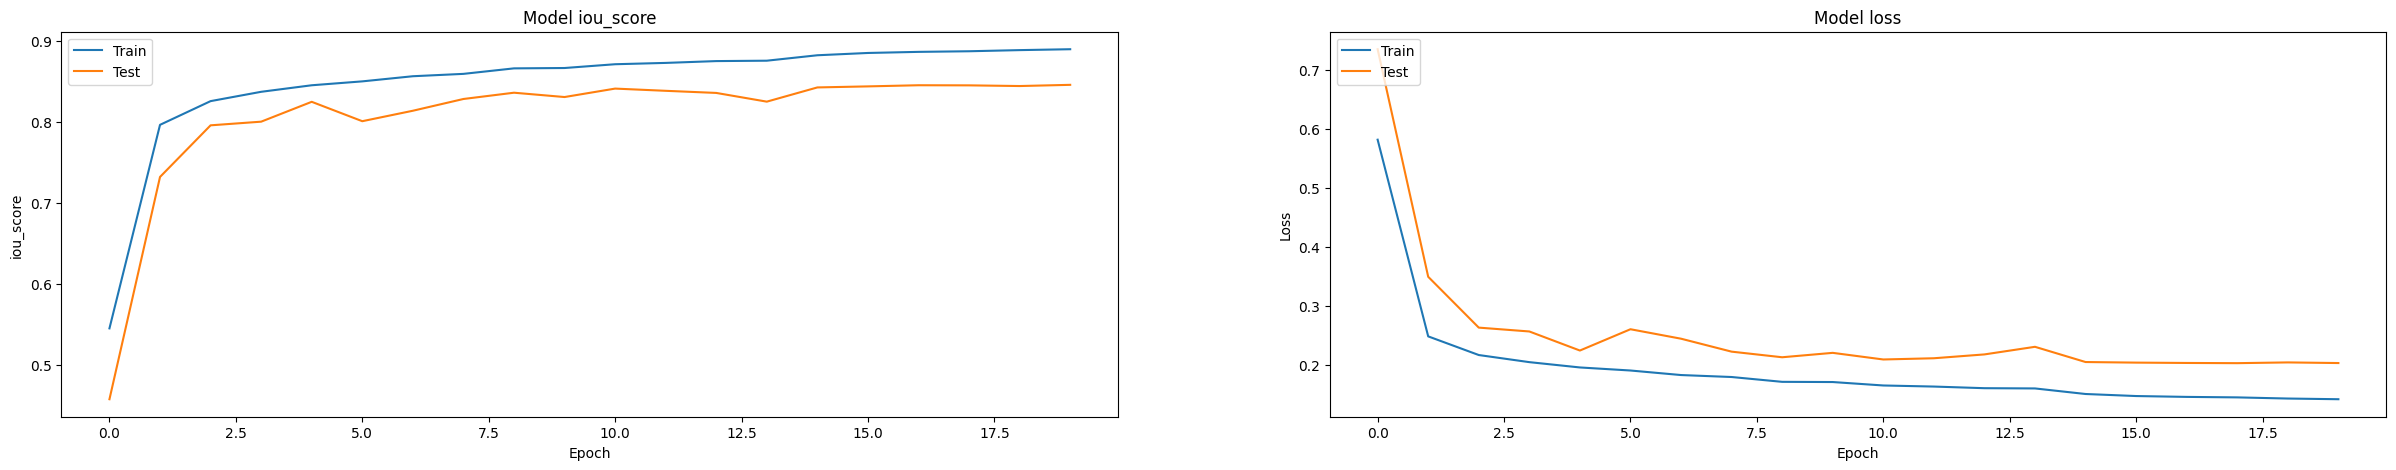

In [12]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
 model.evaluate(val_gen,steps=validation_steps)

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 665ms/step - iou_score: 0.8402 - loss: 0.2075


[0.20384734869003296, 0.8440048098564148]

E0000 00:00:1749299995.880618      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749299996.029349      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


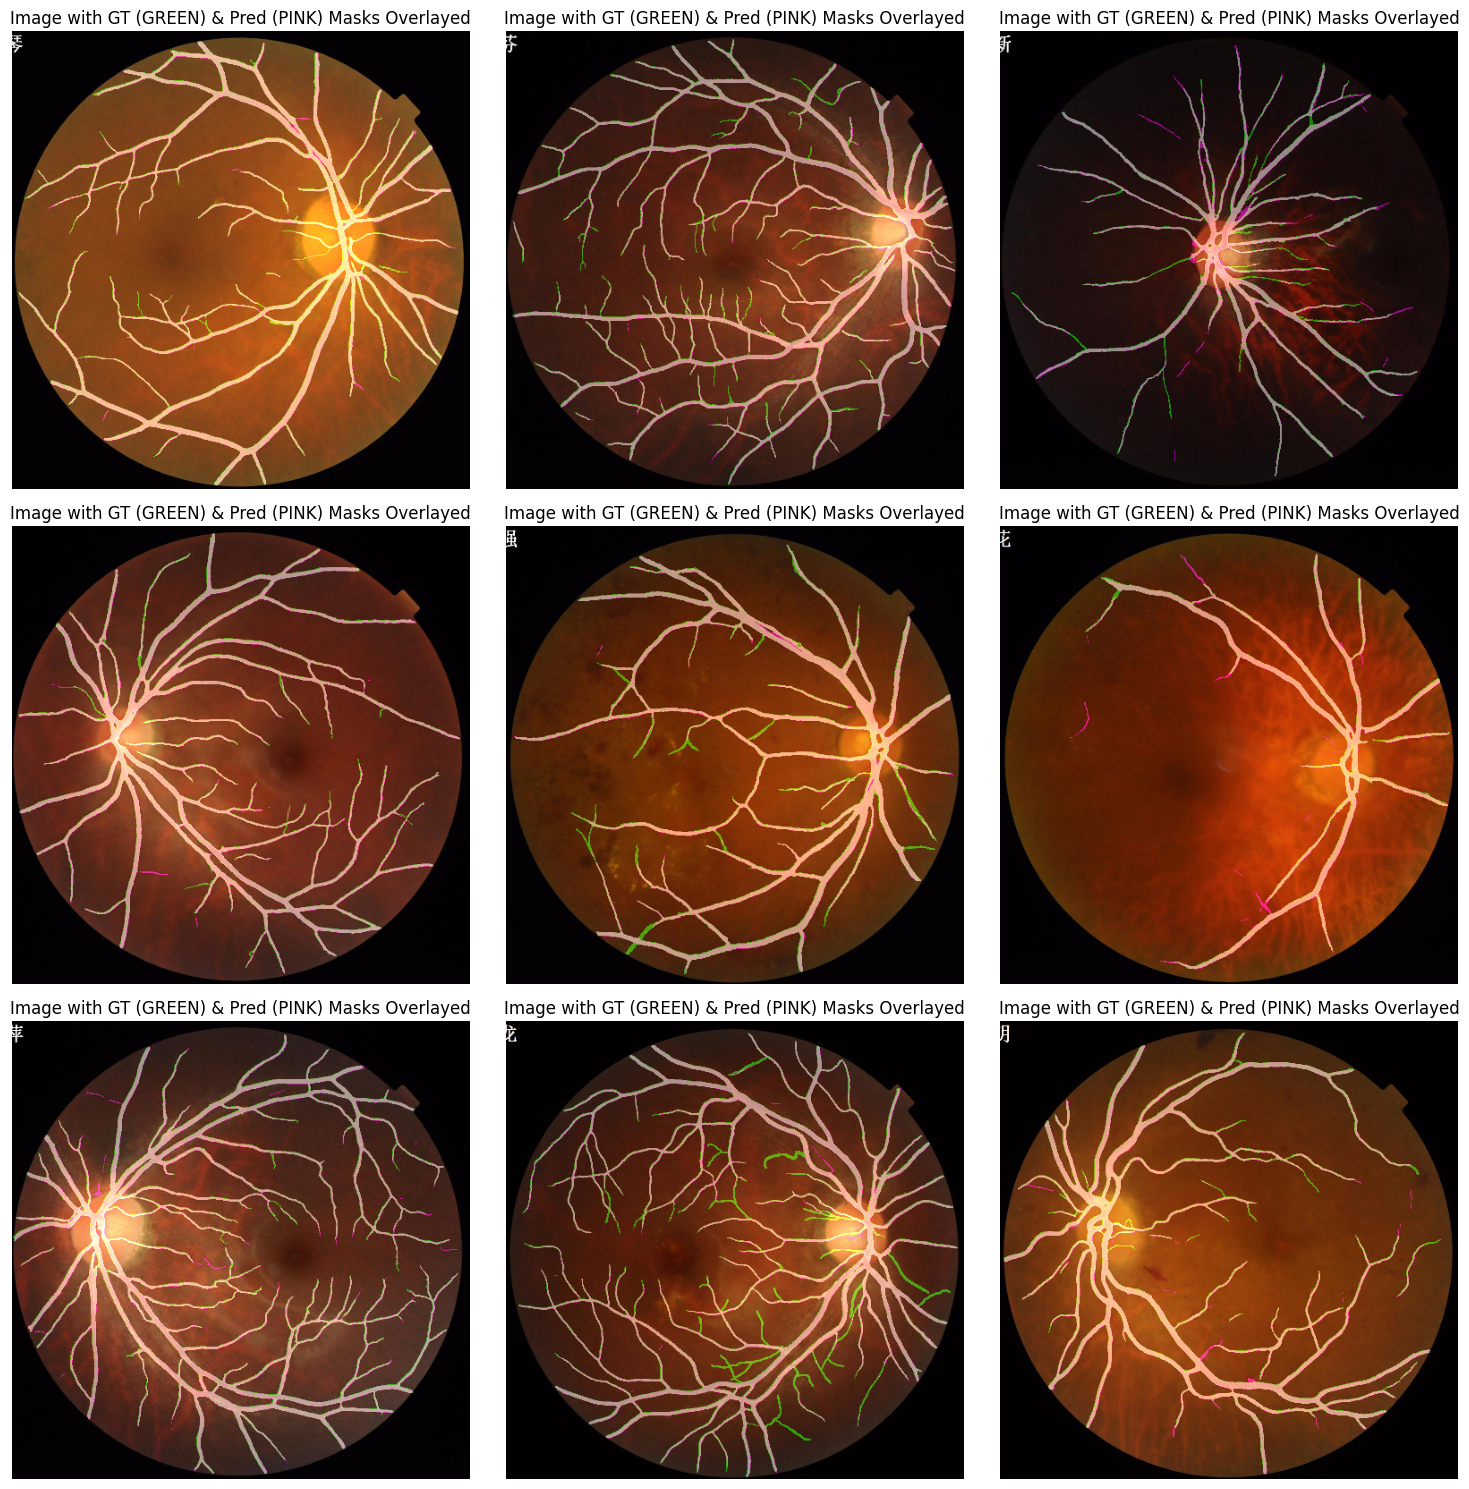

In [14]:
def display_examples(image_paths, mask_paths, model, num_examples=9, img_size=IMAGE_SIZE):
    # Ensure num_examples is a perfect square for grid layout
    grid_size = int(np.ceil(np.sqrt(num_examples)))
    num_examples = grid_size * grid_size

    plt.figure(figsize=(grid_size * 5, grid_size * 5)) # Adjust figure size
    
    displayed_count = 0
    while displayed_count < num_examples:
        idx = random.randint(0, len(image_paths) - 1)
        img_path = image_paths[idx]
        mask_path = mask_paths[idx]

        try:
            # Read image and mask using OpenCV
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize for display and model input
            img_display = cv2.resize(img, img_size)
            mask_display = cv2.resize(mask, img_size)

            # Preprocess for prediction
            img_input = cv2.resize(img, img_size).astype(np.float32) / 255.0
            img_input = np.expand_dims(img_input, axis=0) # Add batch dimension

            # Get prediction
            pred_mask = model.predict(img_input,verbose=0)[0] # Remove batch dimension
            if pred_mask.shape[-1] == 1: # Binary case
                pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
                pred_mask = np.squeeze(pred_mask, axis=-1) # Remove last dimension
            else: # Multi-class case
                pred_mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)
                pred_mask = pred_mask * (255 // (NUM_CLASSES -1)) if NUM_CLASSES > 1 else pred_mask # Scale for visualization
            mask_display_color = cv2.cvtColor(mask_display, cv2.COLOR_GRAY2BGR)
            pred_mask_color = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)
            overlay_gt = img_display.copy()
            overlay_pred = img_display.copy()

            # Color for Ground Truth mask (Green)
            green_mask = np.zeros_like(img_display, dtype=np.uint8)
            green_mask[mask_display > 0] = [0, 255, 0] # Green

            # Color for Predicted mask (Red)
            red_mask = np.zeros_like(img_display, dtype=np.uint8)
            red_mask[pred_mask > 0] = [255, 0, 255] # pink

            alpha = 0.5
            combined_overlay = cv2.addWeighted(green_mask, alpha, red_mask, alpha, 0)
            final_image = cv2.addWeighted(img_display.astype(np.uint8), 1.0, combined_overlay.astype(np.uint8), 1.0, 0)

            plt.subplot(grid_size, grid_size, displayed_count + 1) # Use grid_size for subplot
            plt.imshow(final_image)
            plt.title(f'Image with GT (GREEN) & Pred (PINK) Masks Overlayed')
            plt.axis('off')
            
            displayed_count += 1

        except Exception as e:
            print(f"Could not display example {idx}: {e}")
            continue

    plt.tight_layout()
    plt.show()

display_examples(test_image_files, test_mask_files, model, num_examples=9) # Set num_examples to 9 for 3x3

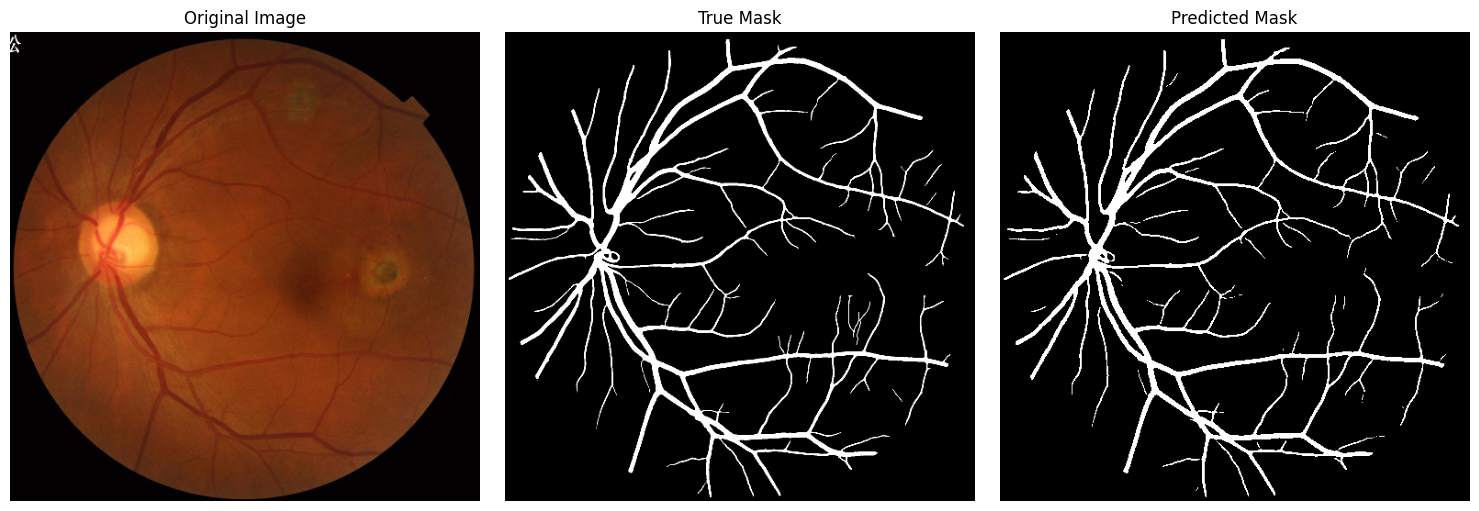

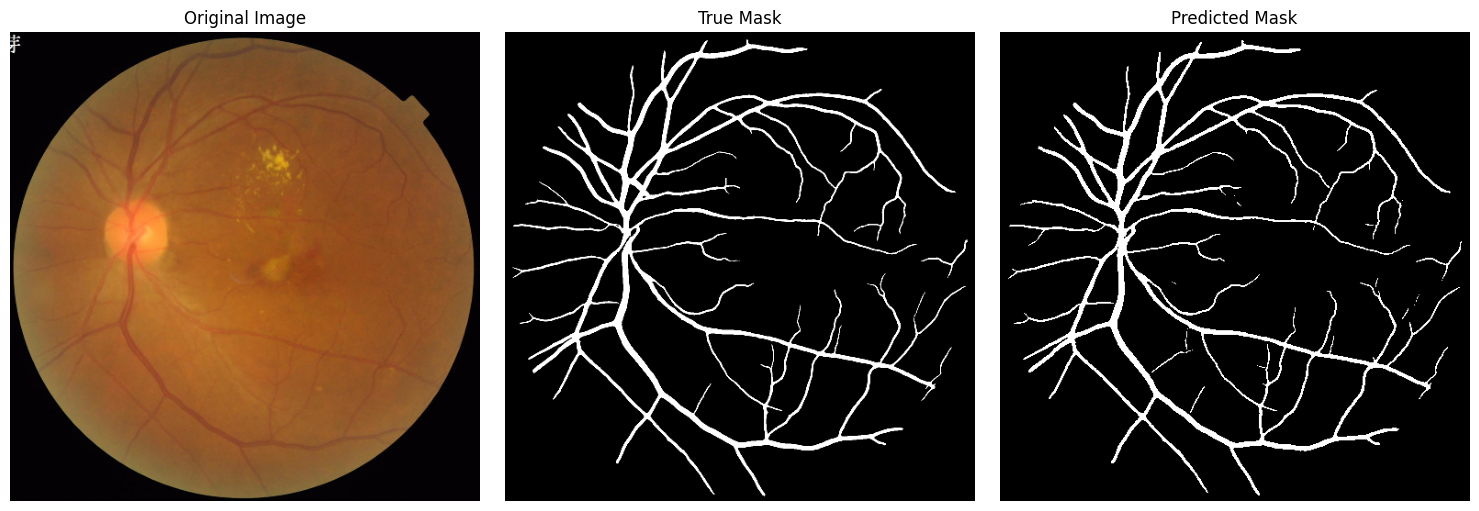

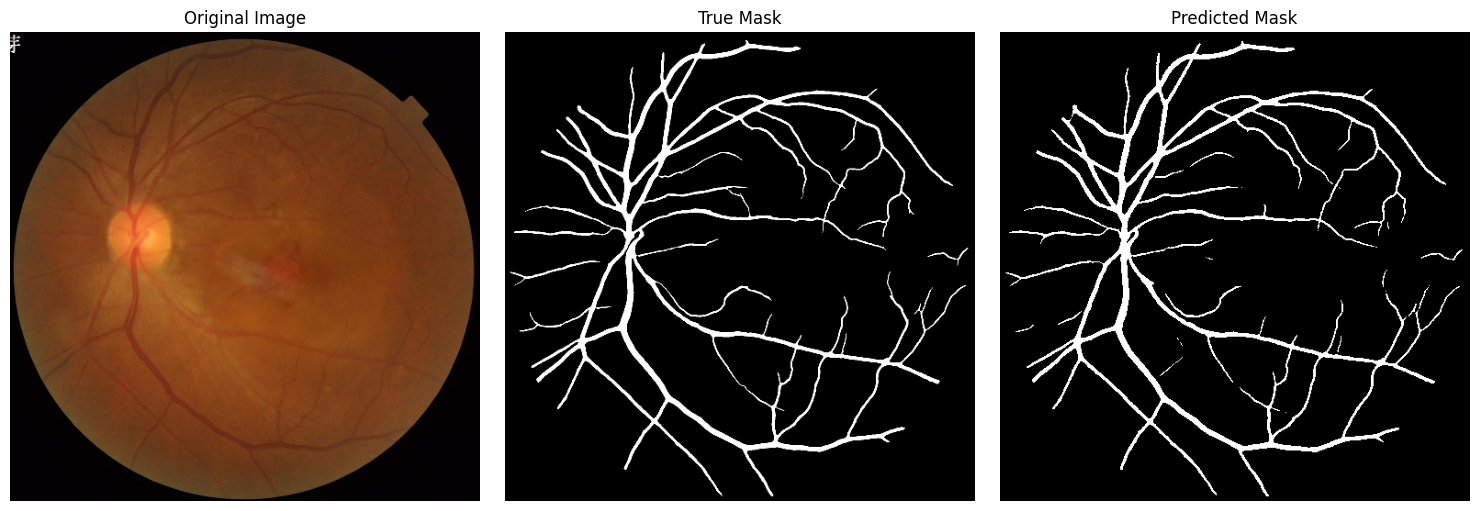

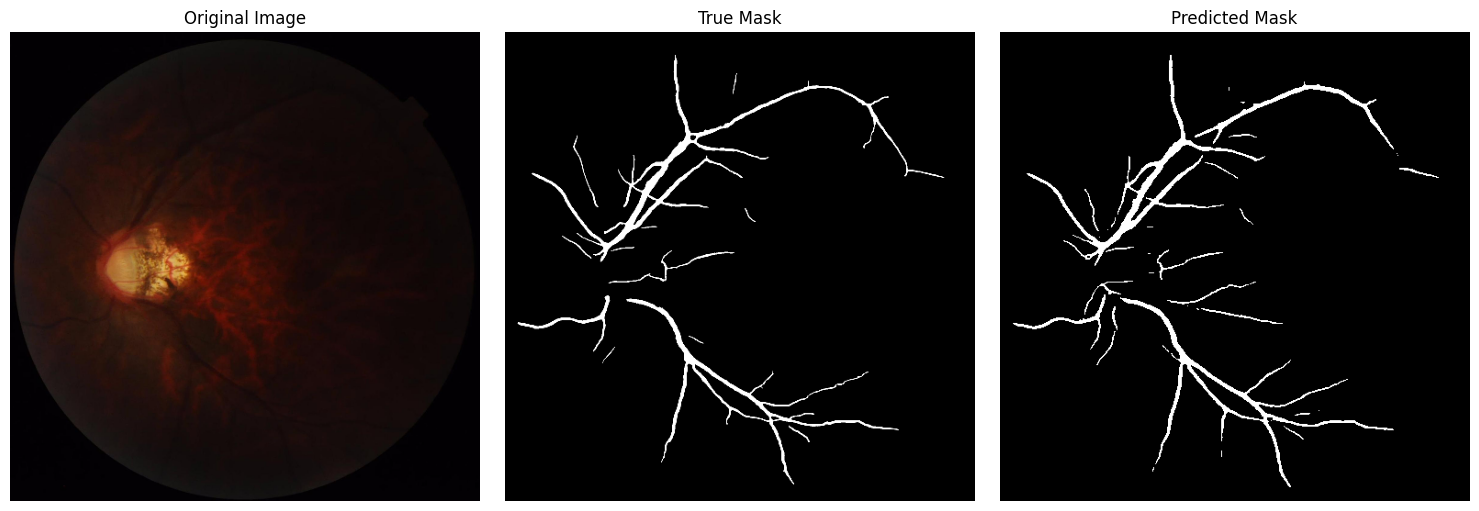

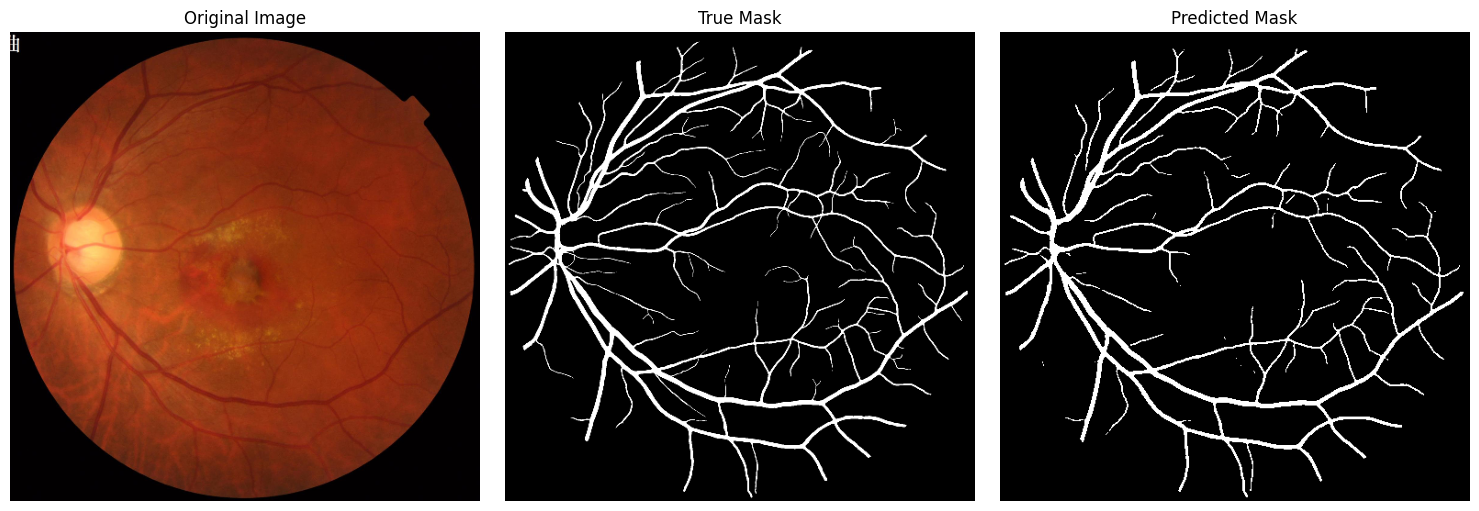

In [15]:
def display_individual_examples(image_paths, mask_paths, model, num_examples=5, img_size=IMAGE_SIZE):
    """Displays individual examples of image, true mask, and predicted mask."""
    
    for i in range(num_examples):
        idx = random.randint(0, len(image_paths) - 1)
        img_path = image_paths[idx]
        mask_path = mask_paths[idx]

        try:
            # Read image and mask using OpenCV
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize for display and model input
            img_display = cv2.resize(img, img_size)
            mask_display = cv2.resize(mask, img_size)

            # Preprocess for prediction
            img_input = cv2.resize(img, img_size).astype(np.float32) / 255.0
            img_input = np.expand_dims(img_input, axis=0) # Add batch dimension

            # Get prediction
            pred_mask = model.predict(img_input,verbose=0)[0] # Remove batch dimension
            if pred_mask.shape[-1] == 1: # Binary case
                pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
                pred_mask = np.squeeze(pred_mask, axis=-1) # Remove last dimension
            else: # Multi-class case
                pred_mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)
                pred_mask = pred_mask * (255 // (NUM_CLASSES -1)) if NUM_CLASSES > 1 else pred_mask # Scale for visualization

            # Display the images
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img_display)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(mask_display, cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not display example {idx}: {e}")
            continue

display_individual_examples(test_image_files, test_mask_files, model, num_examples=5)